In [27]:
import tensorflow as tf
import pandas as pd
import os

from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib import patches
from tensorflow.python.ops.numpy_ops import np_config

from src.swin_transformer.model import *
from src.swin_transformer.helper import *
from src.swin_transformer.patches import *
from src.swin_transformer.window_attn import *

from src.data_prepare import preprocess_data


In [24]:
np_config.enable_numpy_behavior()

# Data errors

In [28]:
annot_df = {'img_name' : [],'classes' : [],'x' : [],'y' : [],'width' : [],'height' : []}
sample = {'image' : [],'bbox' : [],'label' : []}
empty_list = []
for idx,i in tqdm(enumerate(os.listdir('kaggle/train/labels/'))):
    ## Empty Labels
    try:
        tmp_df = pd.read_csv(f'kaggle/train/labels/{i}',header=None)
        for j in tmp_df[0].values:
            annot_df['img_name'].append(f'kaggle/train/images/{i.split(".")[0]}.png')
            #sample['image'] = Image.open(f'kaggle/train/images/{i.split(".")[0]}.png').convert('RGB')
            annot_df['classes'].append(j.split()[0])
            annot_df['x'].append(j.split()[1])
            annot_df['y'].append(j.split()[2])
            annot_df['width'].append(j.split()[3])
            annot_df['height'].append(j.split()[4])
            ###
            sample['label'].append(j.split()[0])
            sample['bbox'].append(j.split()[1])
            sample['bbox'].append(j.split()[2])
            sample['bbox'].append(j.split()[3])
            sample['bbox'].append(j.split()[4])
    except pd.errors.EmptyDataError:
        empty_list.append(i)
        continue

2474it [00:01, 1496.07it/s]


In [3]:
empty_list

['07081.txt',
 '02528.txt',
 '04966.txt',
 '06229.txt',
 '04285.txt',
 '03798.txt',
 '02448.txt']

In [64]:
def plot_image(value=0):
    # Create figure and axes
    fig, ax = plt.subplots()

    # Load Image 
    image = Image.open(annot_df['img_name'][value])

    # Load xy, width and height
    x = (float(annot_df['x'][value]) - float(annot_df['width'][value]) * 0.5) * image.size[0]
    y = (float(annot_df['y'][value]) - float(annot_df['height'][value]) * 0.5) * image.size[1]
    width = float(annot_df['width'][value]) * image.size[0]
    height = float(annot_df['height'][value]) * image.size[1]
    
    # Dsiplay the image
    ax.imshow(image)

    # Create a Rectangle patch
    rect = patches.Rectangle((x,y),width,height,linewidth=1,edgecolor='r',facecolor='none')

    ax.add_patch(rect)

    plt.show()

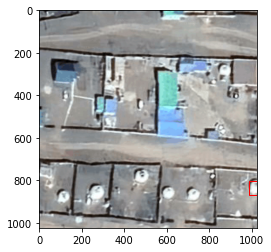

In [67]:
plot_image(0)

In [78]:
def plot_resized_image(resize_size:tuple,value=0):
    # Create figure and axes
    fig, ax = plt.subplots()

    # Load Image 
    image = Image.open(annot_df['img_name'][value])

    # Resize image
    image = tf.image.resize_with_pad(image,resize_size[0],resize_size[1])
    image = image.astype(np.uint8)

    # Load xy, width and height
    x = (float(annot_df['x'][value]) - float(annot_df['width'][value]) * 0.5) * resize_size[0] #image.size[0]
    y = (float(annot_df['y'][value]) - float(annot_df['height'][value]) * 0.5) * resize_size[1] #image.size[1]
    width = float(annot_df['width'][value]) * resize_size[0] #image.size[0]
    height = float(annot_df['height'][value]) * resize_size[1] #image.size[1]
    
    # Dsiplay the image
    ax.imshow(image)

    # Create a Rectangle patch
    rect = patches.Rectangle((x,y),width,height,linewidth=1,edgecolor='r',facecolor='none')

    ax.add_patch(rect)

    plt.show()

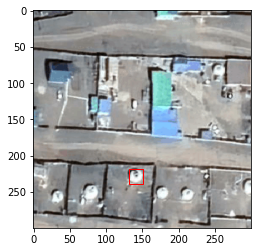

In [80]:
plot_resized_image((300,300),2)

In [25]:
image = tf.image.resize_with_pad(sample['image'],224,224)
image = image.astype(np.uint8)

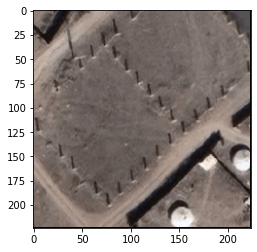

In [26]:
plt.imshow(image)

In [4]:

train_dataset = sample.map(preprocess_data)

AttributeError: 'dict' object has no attribute 'map'